# 03 — Train & Evaluate RUL Models (XGBoost, LSTM, CNN)

This notebook:
- Loads engineered RUL train/val/test splits
- Trains XGBoost regression as a baseline
- Optionally trains LSTM/CNN (with windowed sequences)
- Evaluates models with RMSE/MAE/R².

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

NB_PATH = Path.cwd()

def find_project_root(start: Path) -> Path:
    cur = start
    for _ in range(6):
        if (cur / "requirements.txt").exists() or (cur / "configs").exists() or (cur / "data").exists():
            return cur
        cur = cur.parent
    try:
        i = [p.name.lower() for p in start.parents].index("notebooks")
        return start.parents[i+1]
    except ValueError:
        return start

ROOT = find_project_root(NB_PATH)
DATA_DIR = ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

id_col   = "machine_id"
time_col = "timestamp"
target   = "RUL"

print("ROOT:", ROOT)

ROOT: d:\Documents\Thesis\pdm-project


In [2]:
Xtr = pd.read_parquet(PROCESSED_DIR / "RUL_X_train.parquet")
Xva = pd.read_parquet(PROCESSED_DIR / "RUL_X_val.parquet")
Xte = pd.read_parquet(PROCESSED_DIR / "RUL_X_test.parquet")

ytr = pd.read_parquet(PROCESSED_DIR / "RUL_y_train.parquet")[target]
yva = pd.read_parquet(PROCESSED_DIR / "RUL_y_val.parquet")[target]
yte = pd.read_parquet(PROCESSED_DIR / "RUL_y_test.parquet")[target]

print("Train:", Xtr.shape, ytr.shape)
print("Val:  ", Xva.shape, yva.shape)
print("Test: ", Xte.shape, yte.shape)

Train: (650207, 275) (650207,)
Val:   (3035, 275) (3035,)
Test:  (3514, 275) (3514,)


In [3]:
def pick_numeric_feats(df):
    skip = {id_col, time_col, "__line"}
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in skip]

def to_numeric_matrix(df, feats, for_nn=False):
    X = df[feats].copy()
    X = X.apply(pd.to_numeric, errors='coerce')
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if for_nn:
        X = X.fillna(0.0).astype("float32")
    else:
        X = X.astype("float32")
    return X

def compute_metrics_reg(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "mae": mae, "r2": r2}

In [4]:
def build_windows_reg(X_df, y_vec, window=20, stride=10, id_col="machine_id"):
    X_df = X_df.copy()
    X_df[id_col] = X_df[id_col].values

    feats = [c for c in X_df.columns if c not in [id_col]]
    X_mat = X_df[feats].values
    y = np.asarray(y_vec)

    X_w_list = []
    y_w_list = []

    start = 0
    n = len(X_df)
    while start + window <= n:
        end = start + window
        X_w_list.append(X_mat[start:end, :])
        y_w_list.append(y[end - 1])
        start += stride

    if not X_w_list:
        return np.empty((0, window, len(feats)), dtype="float32"), np.empty((0,), dtype="float32"), feats

    X_w = np.stack(X_w_list).astype("float32")
    y_w = np.asarray(y_w_list, dtype="float32")
    return X_w, y_w, feats

In [5]:
algo = "cnn"  # or "lstm", "cnn"
random_seed = 42

results = {}

if algo == "xgboost":
    import xgboost as xgb

    feats = pick_numeric_feats(Xtr)
    Xtr_mat = to_numeric_matrix(Xtr, feats, for_nn=False)
    Xva_mat = to_numeric_matrix(Xva, feats, for_nn=False)
    Xte_mat = to_numeric_matrix(Xte, feats, for_nn=False)

    ytr_vec = ytr.values.astype("float32")
    yva_vec = yva.values.astype("float32")
    yte_vec = yte.values.astype("float32")

    model = xgb.XGBRegressor(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=random_seed,
        n_jobs=-1,
        objective="reg:squarederror",
        tree_method="hist"
    )

    model.fit(Xtr_mat, ytr_vec, eval_set=[(Xva_mat, yva_vec)], verbose=False)

    yte_pred = model.predict(Xte_mat)
    results["y_pred"] = yte_pred
    results["feats"] = feats
    results["model"] = model

elif algo == "lstm":
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np

    feats = pick_numeric_feats(Xtr)
    Xtr_mat = to_numeric_matrix(Xtr, feats, for_nn=True)
    Xva_mat = to_numeric_matrix(Xva, feats, for_nn=True)
    Xte_mat = to_numeric_matrix(Xte, feats, for_nn=True)

    scaler = StandardScaler()
    Xtr_scaled = scaler.fit_transform(Xtr_mat)
    Xva_scaled = scaler.transform(Xva_mat)
    Xte_scaled = scaler.transform(Xte_mat)

    Xtr_df = pd.concat([Xtr[[id_col]].reset_index(drop=True),
                        pd.DataFrame(Xtr_scaled, columns=feats)], axis=1)
    Xva_df = pd.concat([Xva[[id_col]].reset_index(drop=True),
                        pd.DataFrame(Xva_scaled, columns=feats)], axis=1)
    Xte_df = pd.concat([Xte[[id_col]].reset_index(drop=True),
                        pd.DataFrame(Xte_scaled, columns=feats)], axis=1)

    ytr_vec = ytr.values.astype("float32")
    yva_vec = yva.values.astype("float32")
    yte_vec = yte.values.astype("float32")

    window = 20
    stride = 10
    big_stride = max(stride, 10)

    Xtr_w, ytr_w, feats = build_windows_reg(Xtr_df, ytr_vec, window=window, stride=big_stride, id_col=id_col)
    Xva_w, yva_w, _    = build_windows_reg(Xva_df, yva_vec, window=window, stride=big_stride, id_col=id_col)
    Xte_w, yte_w, _    = build_windows_reg(Xte_df, yte_vec, window=window, stride=big_stride, id_col=id_col)

    max_train_windows = 80_000
    if len(Xtr_w) > max_train_windows:
        idx = np.random.choice(len(Xtr_w), max_train_windows, replace=False)
        Xtr_w = Xtr_w[idx]
        ytr_w = ytr_w[idx]

    print("LSTM train windows:", Xtr_w.shape)

    model = keras.Sequential([
        keras.layers.Input(shape=(window, len(feats))),
        keras.layers.LSTM(64, return_sequences=False),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='mse',
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )

    model.fit(
        Xtr_w, ytr_w,
        validation_data=(Xva_w, yva_w),
        epochs=10,
        batch_size=256,
        verbose=1
    )

    yte_pred = model.predict(Xte_w, batch_size=256).ravel()
    results["y_pred"] = yte_pred
    results["yte_true"] = yte_w
    results["model"] = model
    results["feats"] = feats

elif algo == "cnn":
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np

    feats = pick_numeric_feats(Xtr)
    Xtr_mat = to_numeric_matrix(Xtr, feats, for_nn=True)
    Xva_mat = to_numeric_matrix(Xva, feats, for_nn=True)
    Xte_mat = to_numeric_matrix(Xte, feats, for_nn=True)

    scaler = StandardScaler()
    Xtr_scaled = scaler.fit_transform(Xtr_mat)
    Xva_scaled = scaler.transform(Xva_mat)
    Xte_scaled = scaler.transform(Xte_mat)

    Xtr_df = pd.concat([Xtr[[id_col]].reset_index(drop=True),
                        pd.DataFrame(Xtr_scaled, columns=feats)], axis=1)
    Xva_df = pd.concat([Xva[[id_col]].reset_index(drop=True),
                        pd.DataFrame(Xva_scaled, columns=feats)], axis=1)
    Xte_df = pd.concat([Xte[[id_col]].reset_index(drop=True),
                        pd.DataFrame(Xte_scaled, columns=feats)], axis=1)

    ytr_vec = ytr.values.astype("float32")
    yva_vec = yva.values.astype("float32")
    yte_vec = yte.values.astype("float32")

    window = 20
    stride = 10
    big_stride = max(stride, 10)

    Xtr_w, ytr_w, feats = build_windows_reg(Xtr_df, ytr_vec, window=window, stride=big_stride, id_col=id_col)
    Xva_w, yva_w, _    = build_windows_reg(Xva_df, yva_vec, window=window, stride=big_stride, id_col=id_col)
    Xte_w, yte_w, _    = build_windows_reg(Xte_df, yte_vec, window=window, stride=big_stride, id_col=id_col)

    max_train_windows = 80_000
    if len(Xtr_w) > max_train_windows:
        idx = np.random.choice(len(Xtr_w), max_train_windows, replace=False)
        Xtr_w = Xtr_w[idx]
        ytr_w = ytr_w[idx]

    print("CNN train windows:", Xtr_w.shape)

    model = keras.Sequential([
        keras.layers.Input(shape=(window, len(feats))),
        keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='mse',
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )

    model.fit(
        Xtr_w, ytr_w,
        validation_data=(Xva_w, yva_w),
        epochs=10,
        batch_size=256,
        verbose=1
    )

    yte_pred = model.predict(Xte_w, batch_size=256).ravel()
    results["y_pred"] = yte_pred
    results["yte_true"] = yte_w
    results["model"] = model
    results["feats"] = feats

else:
    raise ValueError("Unknown algo; use one of: xgboost, lstm, cnn")

CNN train windows: (65019, 20, 272)
Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8545849344.0000 - mae: 70404.6328 - val_loss: 4248985856.0000 - val_mae: 65180.2930
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4480983040.0000 - mae: 51368.9258 - val_loss: 1039456960.0000 - val_mae: 32051.0605
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4155583232.0000 - mae: 47758.1641 - val_loss: 33144202.0000 - val_mae: 944.8835
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3894292992.0000 - mae: 45679.1836 - val_loss: 25252714.0000 - val_mae: 788.2830
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3462275072.0000 - mae: 42243.9531 - val_loss: 24639386.0000 - val_mae: 685.8209
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2708281856.0000 - mae: 36039.7383 - val_loss: 23456614.0000 - val_mae: 1479.8446
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1938479744.0000 - mae: 27936.9863 - val_loss: 2923

In [6]:
import numpy as np

# --- Evaluate & log (RUL regression)
# For xgboost: y_pred is aligned with full yte
# For LSTM/CNN: y_pred is aligned with windowed yte_true
if algo == "xgboost":
    y_true = yte.values.astype("float32")
    y_pred = np.asarray(results["y_pred"], dtype="float32")
else:  # lstm / cnn
    y_true = np.asarray(results["yte_true"], dtype="float32")
    y_pred = np.asarray(results["y_pred"], dtype="float32")

m = compute_metrics_reg(y_true, y_pred)
print("Metrics:", m)
m

Metrics: {'rmse': 2385.801437672465, 'mae': 487.2801818847656, 'r2': -56.11545944213867}


{'rmse': 2385.801437672465, 'mae': 487.2801818847656, 'r2': -56.11545944213867}

In [9]:
# --- Log to experiments/RUL/runs.csv
import pandas as pd, json
from datetime import datetime
from pathlib import Path

EXPERIMENTS_DIR = ROOT / "experiments" / "RUL"
EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)

runs_csv = EXPERIMENTS_DIR / "runs.csv"
if not runs_csv.exists():
    pd.DataFrame(columns=[
        "timestamp", "task", "algo", "line", "seed", "params_json",
        "rmse", "mae", "r2",
        "dataset_hash", "notes", "artifact_dir"
    ]).to_csv(runs_csv, index=False)

# if you have these variables defined above, they will be logged, otherwise defaults
seed = locals().get("random_seed", 42)
line_id = -1              # you can change if you ever train per-line
window_val = locals().get("window", None)

row = {
    "timestamp": datetime.utcnow().isoformat(),
    "task": "RUL",
    "algo": algo,
    "line": line_id,
    "seed": seed,
    "params_json": json.dumps({
        "algo": algo,
        "window": int(window_val) if window_val is not None else None
    }),
    "rmse": m.get("rmse"),
    "mae": m.get("mae"),
    "r2": m.get("r2"),
    "dataset_hash": "",
    "notes": "",
    "artifact_dir": ""
}

df_runs = pd.read_csv(runs_csv)
df_runs = pd.concat([df_runs, pd.DataFrame([row])], ignore_index=True)
df_runs.to_csv(runs_csv, index=False)
print("Logged:", runs_csv)


Logged: d:\Documents\Thesis\pdm-project\experiments\RUL\runs.csv


C:\Users\Richard Dammara\AppData\Local\Temp\ipykernel_23816\3334603461.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_runs = pd.concat([df_runs, pd.DataFrame([row])], ignore_index=True)


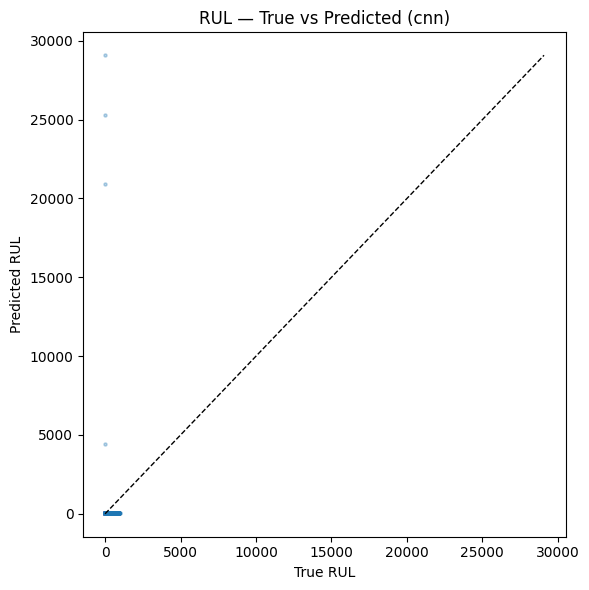

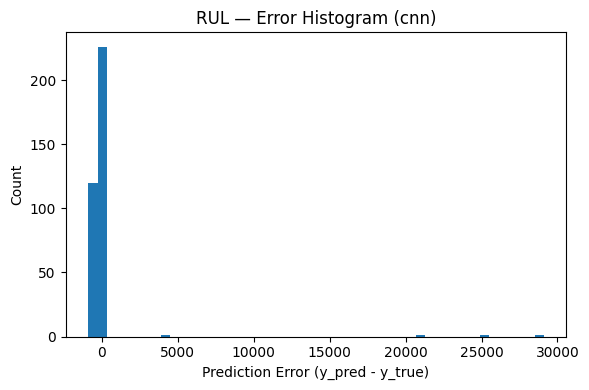

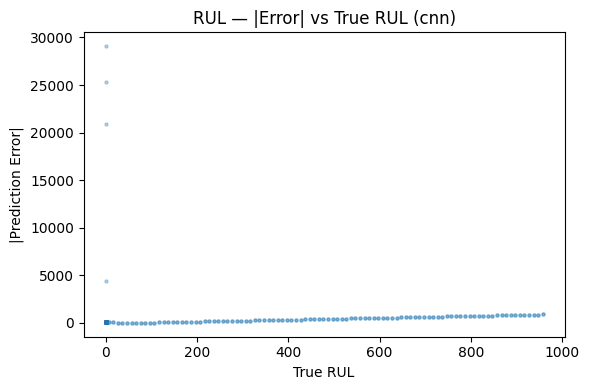

In [10]:
# --- Plots: RUL regression diagnostics
import matplotlib.pyplot as plt

# y_true / y_pred from previous cell
y_true = np.asarray(y_true, dtype="float32")
y_pred = np.asarray(y_pred, dtype="float32")
err = y_pred - y_true

# 1) True vs Predicted scatter
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=5, alpha=0.3)
mn = float(min(y_true.min(), y_pred.min()))
mx = float(max(y_true.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx], "k--", linewidth=1)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title(f"RUL — True vs Predicted ({algo})")
plt.tight_layout()
plt.show()

# 2) Error histogram
plt.figure(figsize=(6,4))
plt.hist(err, bins=50)
plt.xlabel("Prediction Error (y_pred - y_true)")
plt.ylabel("Count")
plt.title(f"RUL — Error Histogram ({algo})")
plt.tight_layout()
plt.show()

# 3) Absolute error vs true RUL
plt.figure(figsize=(6,4))
plt.scatter(y_true, np.abs(err), s=5, alpha=0.3)
plt.xlabel("True RUL")
plt.ylabel("|Prediction Error|")
plt.title(f"RUL — |Error| vs True RUL ({algo})")
plt.tight_layout()
plt.show()
